The main() function orchestrates the execution of these steps. **---** It loads and transforms the data, creates a graph from a polygon, consolidates intersections, saves the graph to a file, converts the graph to GeoDataFrames, saves nodes and edges to files, loads farm data, loads H3 GeoDataFrame, finds the closest OSM ID for each point in the GeoDataFrames, loads farm GeoDataFrame, loads loi data, loads H3 GeoDataFrame, filters H3 GeoDataFrame, and finally calculates the OD matrix. **---** The script is designed to be run as a **standalone program.**

In [1]:
# Import necessary libraries
from utils.cflp_function import *
from utils.calculate_od import *
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points
import pprint

In [2]:
# Define constants
SHAPEFILE_PATH = "shapefiles/zh_poly.shp"
CUSTOM_FILTER = '["highway"]["area"!~"yes"]["access"!~"private"]["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|road"]'
H3_GDF_FILEPATH = 'app_data/h3_pzh_polygons.shp'
TO_CRS = "EPSG:4326"

GRAPHML_FILEPATH = "osm_network/G.graphml"
NODES_FILEPATH = "osm_network/G_n.shp"
EDGES_FILEPATH = "osm_network/G_e.shp"

FARM_FILEPATH = 'farm/pzh_farms.shp'

APP_DATA_H3_GEOMETRY_FILEPATH = "./app_data/h3_geometry.shp"
APP_DATA_FARM_FILEPATH = "./app_data/farm.shp"

LOI_FILEPATH = './hex/loi.csv'
COST_PER_KM = 0.69

This function loads geospatial data from a file and transforms the Coordinate Reference System (CRS) to the specified CRS.

In [3]:
# Function to load and transform geospatial data
def load_and_transform_data(file_path, to_crs=TO_CRS):
    # Load data from file
    data = gpd.read_file(file_path)
    # Transform Coordinate Reference System (CRS)
    data = data.to_crs(to_crs)
    return data

This function creates a graph from a polygon, which represents the study area. The graph is created based on a specified network type and custom filter, and is then projected to the specified CRS.

In [4]:
# Function to create a graph from a polygon
def create_graph_from_polygon(polygon, network_type, custom_filter):
    # Create base graph from polygon
    G_base = ox.graph_from_polygon(polygon, network_type=network_type, custom_filter=custom_filter)
    # Project the graph to a specified CRS
    G_base = ox.project_graph(G_base, to_crs="EPSG:3857")
    return G_base

 This function simplifies the topology of the graph by consolidating intersections within a specified tolerance.

In [5]:
# Function to consolidate intersections in the graph
def consolidate_intersections(G_base, tolerance, rebuild_graph=True, dead_ends=False):
    # Consolidate intersections and simplify the graph
    G = ox.consolidate_intersections(G_base, tolerance=tolerance, rebuild_graph=rebuild_graph, dead_ends=dead_ends)
    return G

This function saves the graph to a file.

In [6]:
# Function to save the graph to a file
def save_graph_to_file(G, filepath):
    ox.save_graphml(G, filepath=filepath, gephi=False)

This function converts lists to strings in the ‘highway’ column of the edges GeoDataFrame.

In [7]:
# Function to convert lists to strings in the 'highway' column of the edges GeoDataFrame
def convert_lists_to_strings(e):
    e['highway'] = e['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [8]:
# Function to save nodes and edges GeoDataFrames to files
def save_nodes_and_edges_to_files(nodes_gdf, edges_gdf, nodes_filepath, edges_filepath):
    nodes_gdf[["geometry", "y", "x", "lon", "lat", "highway"]].to_file(nodes_filepath)
    edges_gdf[["geometry","highway"]].to_file(edges_filepath)

In [9]:
def ensure_point_geometry(gdf):
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.centroid if geom.geom_type != 'Point' else geom)
    return gdf

In [10]:
def save_transformed_data(h3_geodataframe, farm_data, nodes_geodataframe, h3_filepath, farm_filepath):
    # Ensure the geometry is of Point type
    h3_geodataframe = ensure_point_geometry(h3_geodataframe)
    farm_data = ensure_point_geometry(farm_data)

    # Find the closest OSM ID for each point in the GeoDataFrames
    find_closest_osmid(h3_geodataframe, nodes_geodataframe)
    find_closest_osmid(farm_data, nodes_geodataframe)

    # Transform CRS and calculate centroids
    h3_geodataframe = h3_geodataframe.to_crs("EPSG:28992")
    h3_geodataframe['geometry'] = h3_geodataframe['geometry'].centroid
    h3_geodataframe['y'] = h3_geodataframe['geometry'].y
    h3_geodataframe['x'] = h3_geodataframe['geometry'].x

    # Save GeoDataFrames to files
    h3_geodataframe.to_file(h3_filepath)
    farm_data.to_file(farm_filepath)

The main() function orchestrates the execution of these steps. It loads and transforms the data, creates a graph from a polygon, consolidates intersections, saves the graph to a file, converts the graph to GeoDataFrames, saves nodes and edges to files, loads farm data, loads H3 GeoDataFrame, finds the closest OSM ID for each point in the GeoDataFrames, loads farm GeoDataFrame, loads loi data, loads H3 GeoDataFrame, filters H3 GeoDataFrame, and finally calculates the OD matrix.

In [11]:
def main():
    try:
        # Load and transform data
        polygon_data = load_and_transform_data(SHAPEFILE_PATH)
        study_area_polygon = polygon_data['geometry'].squeeze()

        # Create and process graph from polygon
        base_graph = create_graph_from_polygon(study_area_polygon, 'drive', CUSTOM_FILTER)
        print("Number of nodes in the base graph:", len(base_graph.nodes))
        print("Number of edges in the base graph:", len(base_graph.edges))

        tolerance = 50  # adjustable value
        processed_graph = consolidate_intersections(base_graph, tolerance=tolerance)

        # Check for isolated nodes
        isolated_nodes = list(nx.isolates(base_graph))
        print("Number of isolated nodes:", len(isolated_nodes))

        # Remove isolated nodes
        base_graph.remove_nodes_from(isolated_nodes)
        # Rebuild the graph
        processed_graph = consolidate_intersections(base_graph, tolerance=tolerance, rebuild_graph=False)


        # Plot and save base graph
        fig, ax = ox.plot_graph(base_graph, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
        fig.savefig("./base_graph.png", format = 'png', dpi= 1000, bbox_inches="tight")

        # Plot and save processed graph
        fig, ax = ox.plot_graph(processed_graph, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')
        fig.savefig("./processed_graph.png", format = 'png', dpi= 1000, bbox_inches="tight")


        # Save graph to file and convert to GeoDataFrames
        save_graph_to_file(processed_graph, GRAPHML_FILEPATH)
        nodes_geodataframe, edges_geodataframe = ox.graph_to_gdfs(processed_graph)
        
        # Convert lists to strings in the 'highway' column of the edges GeoDataFrame
        convert_lists_to_strings(edges_geodataframe)

        # Save nodes and edges to files
        save_nodes_and_edges_to_files(nodes_geodataframe, edges_geodataframe, NODES_FILEPATH, EDGES_FILEPATH)
        

        ###
        # # t = gpd.read_file(SHAPEFILE_PATH)
        # nodes_geodataframe.head()
        # polygon_data.head()

        # fig, ax = plt.subplots(figsize=(10,12))
        # polygon_data.plot(ax=ax, color='gold', zorder=1)
        # polygon_data.plot(ax=ax, edgecolor='red', color="none", zorder=2)
        # edges_geodataframe.plot(ax=ax, color='darkgray', linewidth=1, zorder=3)
        # nodes_geodataframe.plot(ax=ax, color='tab:blue',  markersize=1, zorder=4)

        # ax.set_axis_off()
        # plt.show()
        # fig.savefig("Diagram/osm_network.png", format='png', dpi=1000, bbox_inches="tight") #transparent=True
        # fig.savefig("Diagram/osm_network.eps", format='eps', dpi=1000, bbox_inches="tight")
        # ###


        # Load farm data and H3 GeoDataFrame
        farm_data = load_and_transform_data(FARM_FILEPATH)
        h3_geodataframe = load_and_transform_data(H3_GDF_FILEPATH)

        # Save transformed data
        save_transformed_data(h3_geodataframe, farm_data, nodes_geodataframe, APP_DATA_H3_GEOMETRY_FILEPATH, APP_DATA_FARM_FILEPATH)


        # Load farm GeoDataFrame and loi data
        farm_geodataframe = gpd.read_file(APP_DATA_FARM_FILEPATH)
        loi_data = gpd.read_file(LOI_FILEPATH)

        # Load H3 GeoDataFrame and filter it
        h3_geodataframe = gpd.read_file(APP_DATA_H3_GEOMETRY_FILEPATH)
        filtered_loi_geodataframe = h3_geodataframe[h3_geodataframe['hex9'].isin(loi_data.hex9)]

        # Calculate OD matrix
        cost_matrix, plant_list = calculate_od_matrix(farm_geodataframe, filtered_loi_geodataframe, COST_PER_KM)

        print("Cost Matrix: ")
        pprint.pprint(cost_matrix)
        print("Plant List: ")
        pprint.pprint(plant_list)

        print('end')
    except Exception as error:
        print(f"An error occurred: {error}")

Number of nodes in the base graph: 15013
Number of edges in the base graph: 27296
Number of isolated nodes: 0


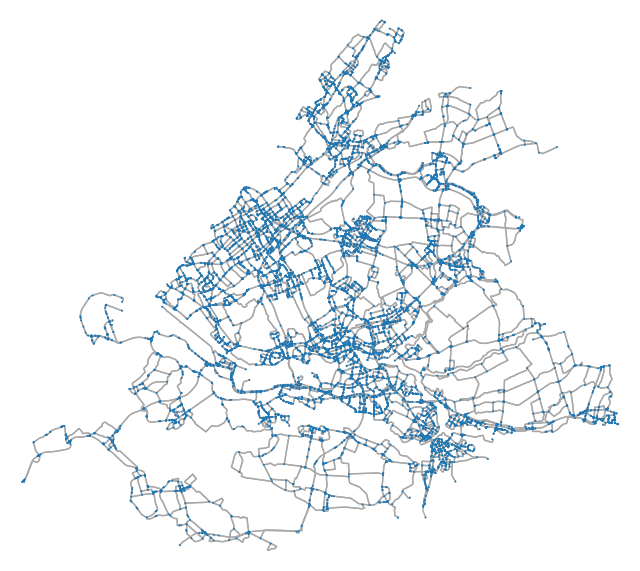

An error occurred: 'GeoSeries' object has no attribute 'graph'


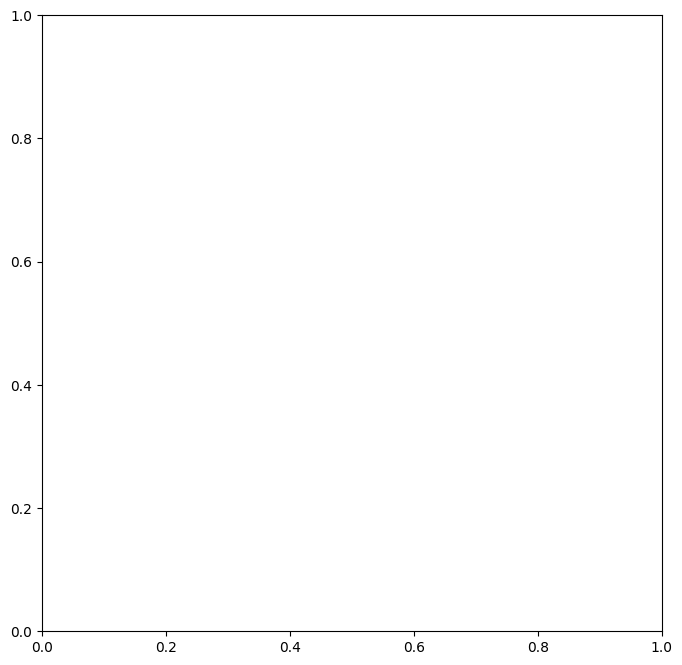

In [12]:
# try:
if __name__ == "__main__":
    main()
# except Exception as error:
#     print(f"An error occurred: {error}")